In [522]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import FigureCanvasPdf, PdfPages
plt.rcParams['axes.spines.top']=False
plt.rcParams['axes.spines.right']=False
plt.rcParams['image.cmap'] = 'inferno'
font = {'family' : 'arial',
        'weight' : 'regular',
        'size'   : 12}
plt.rc('font', **font)

import pandas as pd
from neurodsp import sim, plts
import numpy as np
from numpy import log10
from scipy import random, signal, stats
from scipy.optimize import minimize
from statsmodels.tsa.stattools import acf
from sklearn.decomposition import PCA

In [167]:
from scipy.stats import expon
def lorentzian(f, A, k, exp):
    return A/(k+f**exp)

def exp_prob(xs, lambdas):
    return lambdas*np.exp(-xs*lambdas)
#     return expon.pdf(xs,scale=1/lambdas)

In [303]:
# Define the components of the combined signal to simulate
components = {'sim_synaptic_current' : {'n_neurons' : 1000, 'firing_rate' : 2, 't_ker' : 1.0,
                                         'tau_d' : 0.02},
              'sim_oscillation' : {'freq' : 8.2}}

sig = sim.sim_combined(n_seconds=180, fs=1000, components=components, component_variances=[1,0.4])
nperseg=1000
#f_stft, t_stft, stft = signal.stft(sig, fs=1000, window=np.ones(nperseg), nperseg=nperseg, noverlap=0, boundary=None, return_onesided=True)

# compute STFT
f_stft, t_stft, stft = signal.stft(sig, fs=1000, nperseg=nperseg, noverlap=0, boundary=None)

# # compute power and phase
# power, phase = compute_power_phase(stft)
power = abs(stft)**2

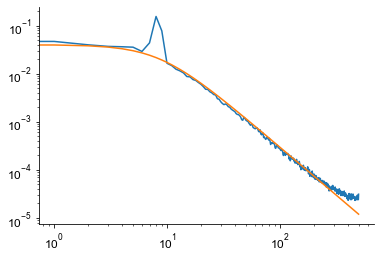

In [304]:
A, k, exp = 3, 75, 2
plt.loglog(np.mean(power,1))
plt.loglog(f_stft, lorentzian(f_stft, A, k, exp))

In [398]:
def spectral_logL(params, data_f, data_p):
    A, k, exp = params
    logL = []
    for i_f, f in enumerate(data_f):
        lmb = 1/lorentzian(f, A, k, exp)
    #     lmb = 1/p.mean()
        logL.append(np.log10(exp_prob(data_p[i_f],lmb)))
    
    return np.array(logL)

def total_neglogL(params, data_f, data_p):
    return -np.array(spectral_logL(params, data_f, data_p)).sum()

#     plt.plot(f_stft,np.array(logL).mean(1))


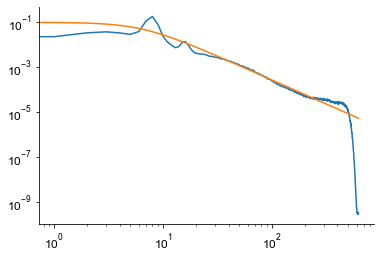

In [399]:
res = minimize(total_neglogL, (2, 50, 2), (f_stft[2:100], power[2:100]))
res.x
A, k, exp = res.x
plt.loglog(np.mean(power,1))
plt.loglog(f_stft, lorentzian(f_stft, A, k, exp))

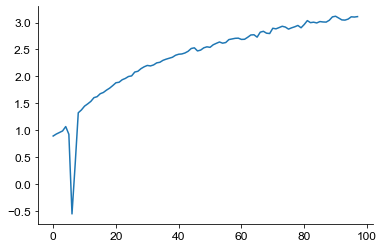

In [307]:
# plt.imshow(np.log10(power[:100]))
slogL = spectral_logL(res.x, f_stft[2:100], power[2:100])
# plt.imshow(slogL)
plt.plot(slogL.mean(1))

In [400]:
from scipy import io
data = io.loadmat('/Users/rdgao/Documents/data/CRCNS/hc2/Raw/lfp_spiketimes_ec013.527.mat', squeeze_me=True)
fs = data['srate']
lfp = data['data'][20]
lfp = (lfp-lfp.mean())/np.std(lfp)
# compute STFT
f_stft, t_stft, stft = signal.stft(lfp[int(fs*30):-int(fs*30)], fs=fs, nperseg=int(fs), noverlap=0, boundary=None)
power = abs(stft)**2

      fun: -231469.61225872856
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00873115, -0.00582077, -0.19208528])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 168
      nit: 35
   status: 0
  success: True
        x: array([  6.38351872, 101.86160935,   2.20536086])
      fun: -231.23837386756728
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.42108547e-04, -5.68434189e-06, -2.24531505e-03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 184
      nit: 37
   status: 0
  success: True
        x: array([  6.38425259, 101.8702381 ,   2.20538623])


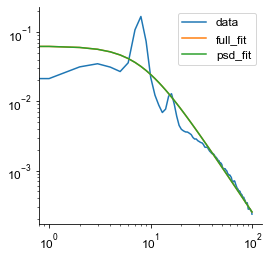

In [402]:
bounds = [[0.01,10],[10,1000],[0,4]]
x0 = (1, 20, 2)
res = minimize(total_neglogL, x0, (f_stft[:100], power[:100]), bounds=bounds)
print(res)
res_psd = minimize(total_neglogL, x0, (f_stft[:100], power.mean(1)[:100]), bounds=bounds)
print(res_psd)

plt.figure(figsize=(4,4))
plt.loglog(f_stft[:100], np.mean(power,1)[:100], label='data')
A, k, exp = res.x
plt.loglog(f_stft[:100], lorentzian(f_stft, A, k, exp)[:100], label='full_fit')
A, k, exp = res_psd.x
plt.loglog(f_stft[:100], lorentzian(f_stft, A, k, exp)[:100], label='psd_fit')
plt.legend()

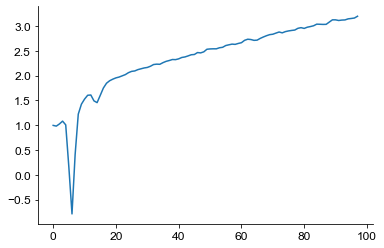

In [403]:
slogL = spectral_logL(res.x, f_stft[2:100], power.mean(1)[2:100])
# plt.imshow(slogL)
# plt.plot(-slogL)
# plt.xscale('log')

slogL = spectral_logL(res.x, f_stft[2:100], power[2:100])
# plt.imshow(slogL)
plt.plot(np.mean(slogL,1))

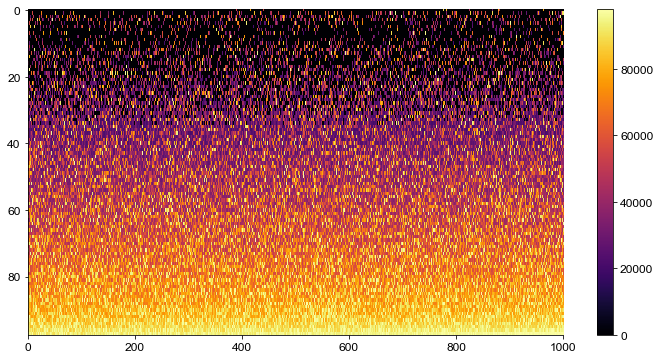

In [417]:
plt.figure(figsize=(12,6))
# plt.imshow(-np.argsort(slogL, axis=0), aspect='auto')

nll_rank = np.argsort(slogL, axis=None).reshape(slogL.shape)
plt.imshow(nll_rank*(nll_rank>20000), aspect='auto')
# plt.imshow(np.log10(power[:100,:]), aspect='auto')
plt.colorbar()

In [516]:
def make_df(f_stft, power):
    return pd.DataFrame(np.array([f_stft.repeat(power.shape[1]),power.flatten(), np.nan*np.ones(np.size(power))]).T, 
                        columns=['freq', 'power', 'lh'])

def compute_logL_flattened(params, data_f, data_p):
    A, k, exp = params
    lmb = 1/lorentzian(data_f, A, k, exp)
    return np.log10(exp_prob(data_p,lmb))

def total_neglogL(params, data_f, data_p):
    return -compute_logL_flattened(params, data_f, data_p).sum()
#     return -np.array(spectral_logL(params, data_f, data_p)).sum()

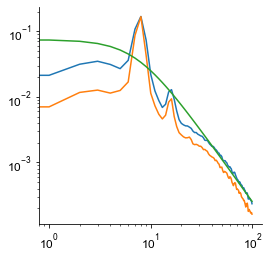

In [712]:
npct = 1
df_spg = make_df(f_stft[:100], power[:100,:])
psd = df_spg.groupby('freq').mean()['power']
psd_med = df_spg.groupby('freq').median()['power']

df_select = df_spg[(df_spg['freq']>=1) & (df_spg['freq']<=100)]

bounds = [[0.01,10],[10,100000],[0,4]]
x0 = (1, 20, 2)
res = minimize(total_neglogL, x0, (df_select['freq'].values, df_select['power'].values), bounds=bounds)
res.x

plt.figure(figsize=(4,4))
plt.loglog(psd.index, psd, label='data mean')
plt.loglog(psd.index, psd_med, label='data median')
A, k, exp = res.x
plt.loglog(psd.index, lorentzian(psd.index, *res.x), label='full_fit')

[ 5.63143952 75.5914837   2.17569832]


/Users/rdgao/opt/anaconda3/envs/voytek/lib/python3.7/site-packages/pandas/core/indexing.py:1047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


[  4.04578958 118.98178068   2.09112076]


/Users/rdgao/opt/anaconda3/envs/voytek/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10
/Users/rdgao/opt/anaconda3/envs/voytek/lib/python3.7/site-packages/scipy/optimize/optimize.py:697: RuntimeWarning: invalid value encountered in double_scalars
  df = (f(*((xk + d,) + args)) - f0) / d[k]


[ 1.07913013 33.4708952   1.75513969]
[  3.20865788 179.31245354   2.03085559]
[  3.67091499 257.81406734   2.06336449]


/Users/rdgao/opt/anaconda3/envs/voytek/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


[  3.96421921 333.58604106   2.08115754]


/Users/rdgao/opt/anaconda3/envs/voytek/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


[  4.34827234 429.75282088   2.10248554]


/Users/rdgao/opt/anaconda3/envs/voytek/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


[  4.68600109 531.91258152   2.11961487]


/Users/rdgao/opt/anaconda3/envs/voytek/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


[  5.09568902 656.66388933   2.13880131]


/Users/rdgao/opt/anaconda3/envs/voytek/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


[  5.70462883 830.18270965   2.16461485]


/Users/rdgao/opt/anaconda3/envs/voytek/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


[   6.62427137 1088.10885873    2.19913297]


/Users/rdgao/opt/anaconda3/envs/voytek/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


[   7.39219593 1341.25628431    2.22425576]


/Users/rdgao/opt/anaconda3/envs/voytek/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


[   8.26233361 1573.21551438    2.25204065]


/Users/rdgao/opt/anaconda3/envs/voytek/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


[   8.26943021 1778.95058374    2.24968175]


/Users/rdgao/opt/anaconda3/envs/voytek/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


[   9.33968768 2196.51031835    2.27689682]


/Users/rdgao/opt/anaconda3/envs/voytek/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


[1.00000000e+01 2.55069750e+03 2.29205172e+00]


/Users/rdgao/opt/anaconda3/envs/voytek/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


[1.00000000e+01 2.73446491e+03 2.29105074e+00]


/Users/rdgao/opt/anaconda3/envs/voytek/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


[1.00000000e+01 2.91795325e+03 2.29051031e+00]


/Users/rdgao/opt/anaconda3/envs/voytek/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


[9.09160328e+00 2.79161779e+03 2.26838179e+00]


/Users/rdgao/opt/anaconda3/envs/voytek/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


[1.00000000e+01 3.27292062e+03 2.29067971e+00]


/Users/rdgao/opt/anaconda3/envs/voytek/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


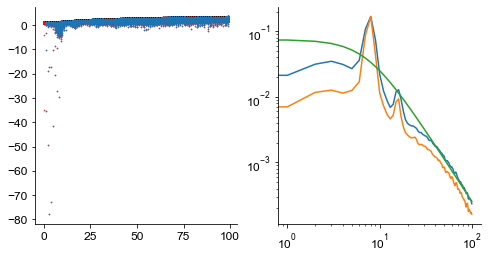

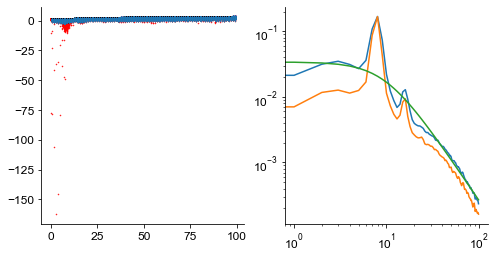

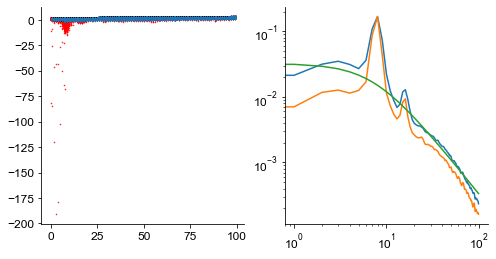

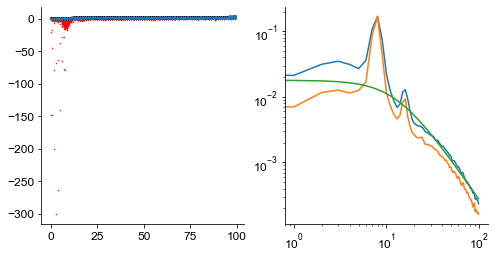

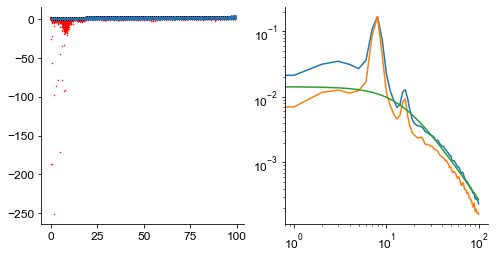

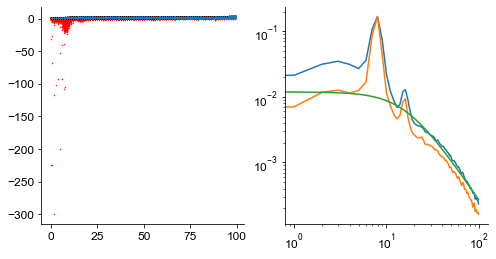

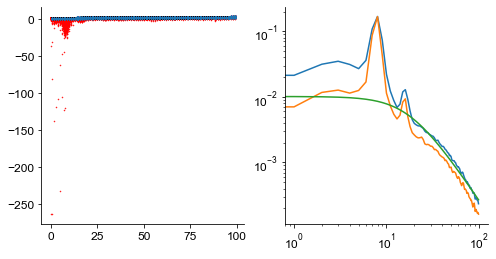

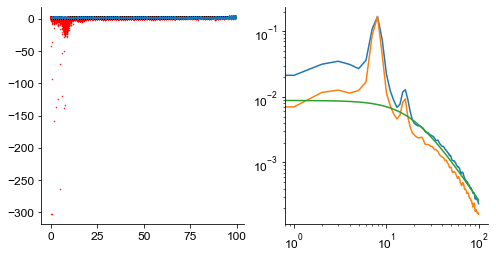

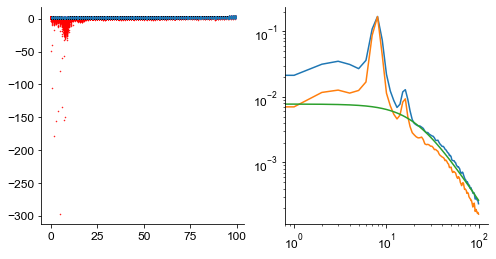

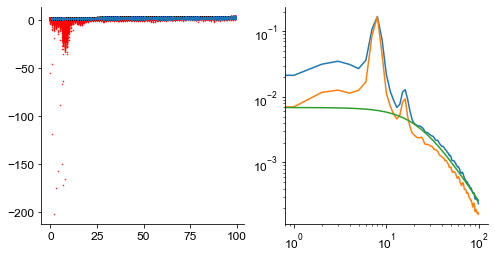

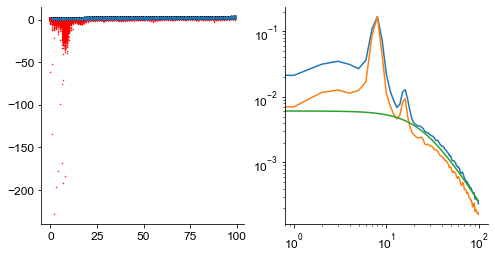

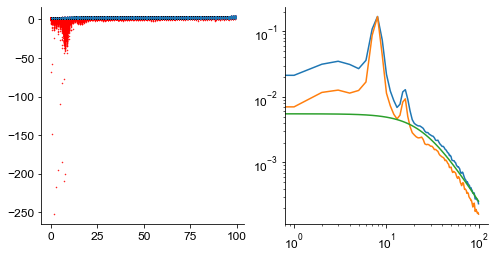

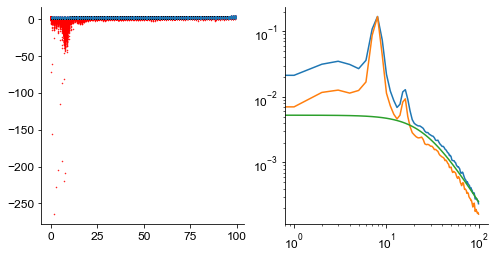

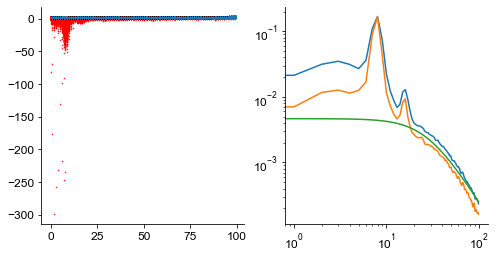

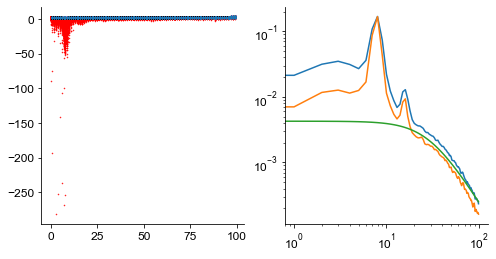

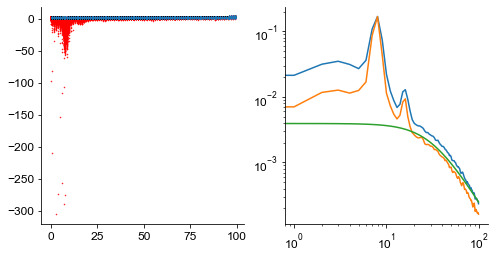

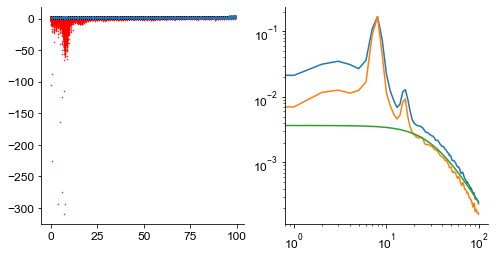

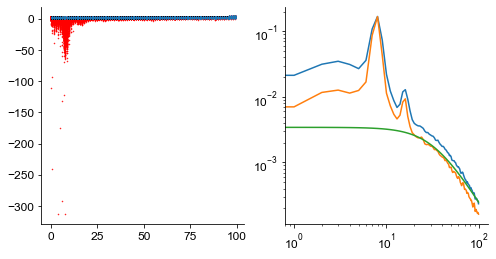

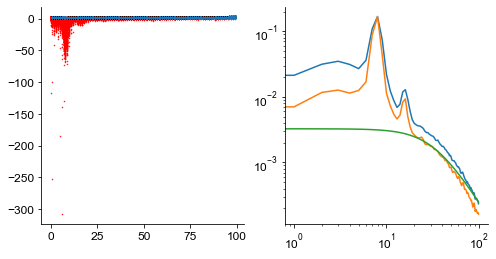

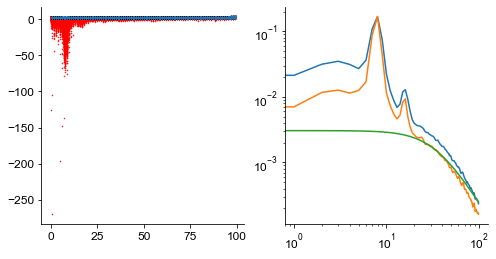

In [713]:
for i in range(20):
    # fit
    res = minimize(total_neglogL, x0, (df_select['freq'].values, df_select['power'].values), bounds=bounds)    
    print(res.x)
    
    psd_trim = df_select.groupby('freq').mean()['power']
    
    # compute point-wise log likelihood
    logL = compute_logL_flattened(res.x, df_spg['freq'], df_spg['power']).values
    
    
    
    # update
    df_spg['lh'] = np.nan
    df_spg.loc[:, 'lh'] = logL
    df_select.loc[:, 'lh'] = logL[df_select.index.values]

    # plot
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.plot(df_spg['freq'],df_spg['lh'], 'r.', ms=1)
    plt.plot(df_select['freq'],df_select['lh'], '.', ms=1)

    plt.subplot(1,2,2)
    plt.loglog(psd.index, psd, label='data')
    plt.loglog(psd_trim.index, psd_trim, label='data trimmed')
    plt.loglog(psd.index, psd_med, label='data median')
    A, k, exp = res.x
    plt.loglog(psd.index, lorentzian(psd.index, *res.x), label='fit')

    # re-subselect
    df_select = df_select[df_select['lh'] >= np.percentile(df_select['lh'],npct)]

In [ ]:
for i in range(20):
    # fit
    res = minimize(total_neglogL, x0, (df_select['freq'].values, df_select['power'].values), bounds=bounds)
    print(res.x)

    # compute point-wise log likelihood
    logL = compute_logL_flattened(res.x, df_select['freq'], df_select['power']).values

    # update
    df_spg['lh'] = np.nan
    df_spg.loc[df_select.index.values, 'lh'] = logL
    df_select.loc[:, 'lh'] = logL

    # plot
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.plot(df_spg['freq'],df_spg['lh'], '.', ms=1)

    plt.subplot(1,2,2)
    plt.loglog(psd.index, psd, label='data')
    A, k, exp = res.x
    plt.loglog(psd.index, lorentzian(psd.index, *res.x), label='full_fit')

    # re-subselect
    df_select = df_select[df_select['lh'] >= np.percentile(df_select['lh'],npct)]